# Use Markov Chain Monte Carlo to sample configurations of a 2D Ising system

In [1]:
%matplotlib inline
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook, trange

In [34]:
# either save spin configurations or write a class to generate spin data (like the later better than the former)
class IsingMonteCarlo:
    
    # Initialization
    def __init__(self, a, J=-1):
        matplotlib.rcParams.update({'font.size': 22})
        self.J = J
        self.a = a
        self.n_spins = a**2
        self.Tc = self._get_Tc(self.J)
        self.neighbours = self._make_neighbours(self.a, self.n_spins)
        self.graph = self._make_graph(self.a, self.n_spins, self.neighbours)
    
    # Auxiliary initialization functions
    def _get_Tc(self, J):
        if J < 0:
            return 2.0/np.log(1.0 + np.sqrt(2)) * (-J)
        else:
            return np.nan
        
    def _make_neighbours(self, a, n_spins):
        # order: right, up, left, down
        neighbours = np.array([[n+1, n+a, n-1, n-a] for n in range(n_spins)])
        # corrections
        neighbours[range(a-1, n_spins, a), 0] -= a # rightmost spins
        neighbours[range(n_spins-a, n_spins), 1] -= n_spins # top spins
        neighbours[range(0, n_spins, a), 2] += a # leftmost spins
        neighbours[range(a), 3] += n_spins # bottom spins
        return neighbours
        
    def _make_graph(self, a, n_spins, neighbours):
        G = nx.Graph()
        G.add_nodes_from(range(n_spins))
        G.add_edges_from([(i, j) for i in range(n_spins) for j in neighbours[i]])
        return G
    
    # Monte Carlo methods
    def initialize_spins_at_random(self):
        spins = np.random.randint(0, 2, self.n_spins)
        spins[spins == 0] = -1
        return spins

    def get_energy(self, spins):
        '''Calculates Ising energy assuming'''
        products = np.array(2*[spins]).T * spins[self.neighbours[:, :2]]
        return self.J * np.sum(products)
    
    def get_magnetization(self, spins):
        return np.sum(spins)

    def get_next_configuration(self, spins, temperature):
        # propose a spin to flip
        site = np.random.randint(0, self.n_spins)
        # accept or reject it
        deltaE = 2 * self.J * np.sum(spins[site] * spins[self.neighbours[site]]) # E_old-E_new
        accept_prob = np.exp(deltaE / temperature) # p_new/p_old = exp(-(E_new-E_old)/T)
        if accept_prob > np.random.random():
            spins[site] *= -1
        return spins
    
    def calibrateMonteCarlo(self, n_steps=1000000, temperature=0.5, plot=True):
        spins = self.initialize_spins_at_random()
        energies = []
        mags = []
        for i in tqdm(range(n_steps)):
            spins = self.get_next_configuration(spins, temperature)
            energies += [self.get_energy(spins)]
            mags += [self.get_magnetization(spins)]
        if plot:
            plt.subplot(211)
            plt.semilogx(energies, 'o-')
            plt.xlabel(r'Temperature')
            plt.ylabel(r'Energy')
            
            plt.subplot(212)
            plt.semilogx(mags, 'o-')
            plt.xlabel(r'Temperature')
            plt.ylabel(r'Magnetization')
            
            plt.tight_layout()
        return energies, mags
    
    def runMonteCarlo(self, 
                      equilibration_steps=5*10**5, # 1000 (5*10**5) for 4 (40) spins
                      measurement_steps=100, 
                      sweeps_per_measurement=None,
                      temperatures=np.linspace(0.5, 5, 20),
                      plot=True):
        if not sweeps_per_measurement:
            sweeps_per_measurement = 3 * self.n_spins
        energy = []
        magnetization = []
        specific_heat = []
        susceptibility = [] # per spin
        spins = self.initialize_spins_at_random()

        for temperature in tqdm(temperatures, desc='Temperatures'):    
            # Achieving steady-state
            for _ in range(equilibration_steps):
                spins = self.get_next_configuration(spins, temperature)

            # Estimating
            e = [self.get_energy(spins)]
            m = [self.get_magnetization(spins)]
            for _i in range(measurement_steps):
                for _ in range(sweeps_per_measurement):
                    spins = self.get_next_configuration(spins, temperature)
                e.append(self.get_energy(spins))
                m.append(self.get_magnetization(spins))

            energy.append( np.mean(e) )
            magnetization.append( np.mean(m) )
            specific_heat.append( np.var(e) / temperature**2 )
            susceptibility.append( np.var(m) / temperature )

        energy = np.array(energy)
        magnetization = np.array(magnetization)
        specific_heat = np.array(specific_heat)
        susceptibility = np.array(susceptibility)
        
        if plot:
            plt.figure(figsize=(15,10))

            plt.subplot(221)
            plt.plot(temperatures, energy / self.n_spins, 'o-')
            plt.plot([self.Tc, self.Tc], [np.min(energy / self.n_spins), np.max(energy / self.n_spins)], '--')
            plt.xlabel(r'Temperature')
            plt.ylabel(r'$\langle E \rangle / N$')

            plt.subplot(222)
            plt.plot(temperatures, np.abs(magnetization / self.n_spins), 'o-')
            plt.plot([self.Tc, self.Tc], [0, 1], '--')
            plt.xlabel(r'Temperature ')
            plt.ylabel(r'$\langle M \rangle / N$')

            plt.subplot(223)
            plt.plot(temperatures, specific_heat , 'o-')
            plt.plot([self.Tc, self.Tc], [specific_heat.min(), specific_heat.max()], '--')
            plt.xlabel(r'Temperature ')
            plt.ylabel(r'$c_V$')

            plt.subplot(224)
            plt.plot(temperatures, susceptibility , 'o-')
            plt.plot([self.Tc, self.Tc], [susceptibility.min(), susceptibility.max()], '--')
            plt.xlabel(r'Temperature ')
            plt.ylabel(r'$\chi / N$')

            plt.tight_layout()
        
        return energy, magnetization, specific_heat, susceptibility

    # Visualization methods
    def draw_graph(self, pos=None):
        if not pos:
            pos = {x+self.a*y: (x,y) for x in range(self.a) for y in range(self.a)}
        nx.draw_networkx(self.graph, pos=pos)
        
ising = IsingMonteCarlo(-1, 40)

In [35]:
ising.Tc

2.2691853142130221

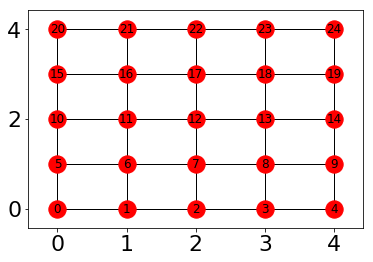

In [31]:
ising.draw_graph()

100%|██████████| 1000000/1000000 [01:06<00:00, 15142.01it/s]


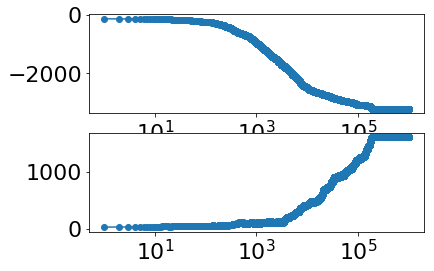

In [36]:
_ = ising.calibrateMonteCarlo()

Temperatures: 100%|██████████| 20/20 [04:46<00:00, 14.61s/it]


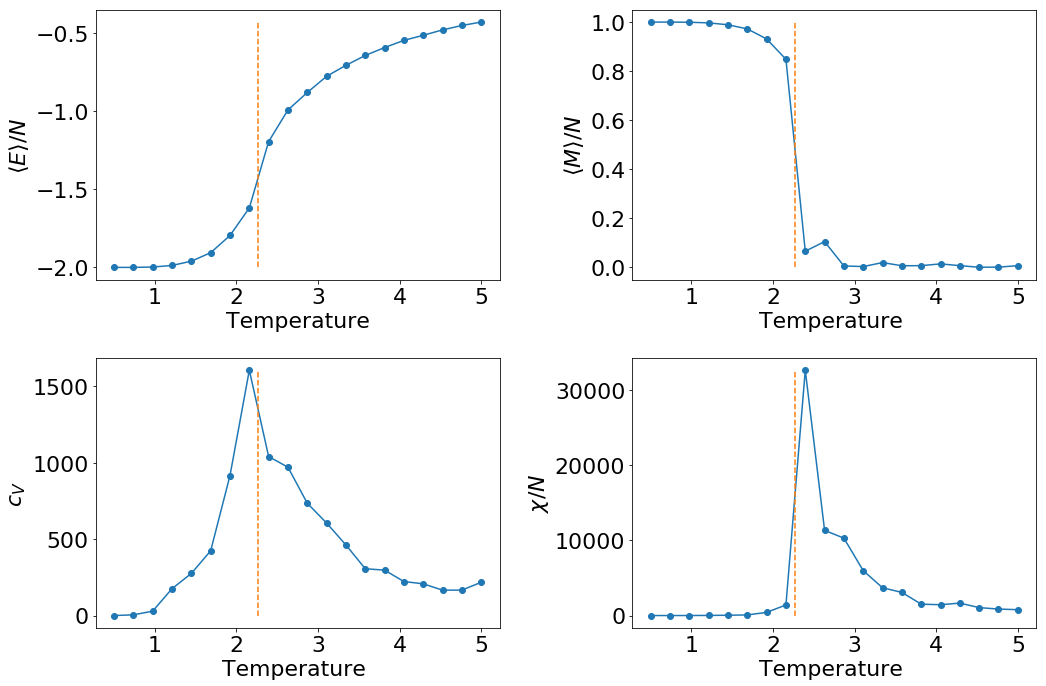

In [37]:
_ = ising.runMonteCarlo()

# NeuralNet to classify states

In [6]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
class Net(nn.Module):
    
    def __init__(self, n_spins=16, n_hidden=2, n_out=2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_spins, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_out)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return x
        
net = Net()

In [5]:
net

Net (
  (fc1): Linear (16 -> 2)
  (fc2): Linear (2 -> 2)
)

In [7]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)